In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
driving_log = pd.read_csv('data/driving_log.csv', names=['center','left','right','angle','throttle','brake','speed'])

In [3]:
center_angle = driving_log[['center','angle']]

In [4]:
def processFilename(filename):
  filename = filename.split('/')
  filename = 'data/{}/{}'.format(filename[-2], filename[-1])
  return filename
# enddef

In [5]:
for row in center_angle.itertuples():
  filename = processFilename(row.center)
  angle = row.angle
  print(filename, angle)
# end for

data/IMG/center_2018_03_08_22_43_52_621.jpg 0.0
data/IMG/center_2018_03_08_22_43_52_689.jpg 0.0
data/IMG/center_2018_03_08_22_43_52_757.jpg 0.0
data/IMG/center_2018_03_08_22_43_52_826.jpg 0.0
data/IMG/center_2018_03_08_22_43_52_893.jpg 0.0
data/IMG/center_2018_03_08_22_43_52_961.jpg 0.0
data/IMG/center_2018_03_08_22_43_53_031.jpg 0.0
data/IMG/center_2018_03_08_22_43_53_101.jpg 0.0
data/IMG/center_2018_03_08_22_43_53_170.jpg 0.0
data/IMG/center_2018_03_08_22_43_53_238.jpg 0.0
data/IMG/center_2018_03_08_22_43_53_307.jpg 0.0
data/IMG/center_2018_03_08_22_43_53_375.jpg 0.0
data/IMG/center_2018_03_08_22_43_53_444.jpg 0.0
data/IMG/center_2018_03_08_22_43_53_514.jpg 0.0
data/IMG/center_2018_03_08_22_43_53_585.jpg 0.0
data/IMG/center_2018_03_08_22_43_53_652.jpg 0.0
data/IMG/center_2018_03_08_22_43_53_719.jpg 0.0
data/IMG/center_2018_03_08_22_43_53_787.jpg 0.0
data/IMG/center_2018_03_08_22_43_53_855.jpg 0.0
data/IMG/center_2018_03_08_22_43_53_924.jpg 0.0
data/IMG/center_2018_03_08_22_43_53_993.

data/IMG/center_2018_03_08_22_45_00_614.jpg -0.08015183
data/IMG/center_2018_03_08_22_45_00_684.jpg -0.08015183
data/IMG/center_2018_03_08_22_45_00_751.jpg -0.08015183
data/IMG/center_2018_03_08_22_45_00_821.jpg -0.08015183
data/IMG/center_2018_03_08_22_45_00_889.jpg -0.08015183
data/IMG/center_2018_03_08_22_45_00_968.jpg -0.08015183
data/IMG/center_2018_03_08_22_45_01_050.jpg -0.08015183
data/IMG/center_2018_03_08_22_45_01_121.jpg -0.08015183
data/IMG/center_2018_03_08_22_45_01_200.jpg -0.08015183
data/IMG/center_2018_03_08_22_45_01_276.jpg -0.08015183
data/IMG/center_2018_03_08_22_45_01_343.jpg -0.08015183
data/IMG/center_2018_03_08_22_45_01_413.jpg -0.08015183
data/IMG/center_2018_03_08_22_45_01_487.jpg -0.08015183
data/IMG/center_2018_03_08_22_45_01_556.jpg -0.08015183
data/IMG/center_2018_03_08_22_45_01_623.jpg -0.08015183
data/IMG/center_2018_03_08_22_45_01_690.jpg -0.08015183
data/IMG/center_2018_03_08_22_45_01_759.jpg -0.08015183
data/IMG/center_2018_03_08_22_45_01_829.jpg -0.0

data/IMG/center_2018_03_08_22_45_52_645.jpg -0.1099278
data/IMG/center_2018_03_08_22_45_52_716.jpg -0.1099278
data/IMG/center_2018_03_08_22_45_52_786.jpg -0.1099278
data/IMG/center_2018_03_08_22_45_52_855.jpg -0.1099278
data/IMG/center_2018_03_08_22_45_52_924.jpg -0.1099278
data/IMG/center_2018_03_08_22_45_52_994.jpg -0.1099278
data/IMG/center_2018_03_08_22_45_53_063.jpg -0.1099278
data/IMG/center_2018_03_08_22_45_53_133.jpg -0.1122126
data/IMG/center_2018_03_08_22_45_53_201.jpg -0.114829
data/IMG/center_2018_03_08_22_45_53_271.jpg -0.114829
data/IMG/center_2018_03_08_22_45_53_339.jpg -0.114829
data/IMG/center_2018_03_08_22_45_53_409.jpg -0.114829
data/IMG/center_2018_03_08_22_45_53_478.jpg -0.114829
data/IMG/center_2018_03_08_22_45_53_550.jpg -0.114829
data/IMG/center_2018_03_08_22_45_53_620.jpg -0.114829
data/IMG/center_2018_03_08_22_45_53_692.jpg -0.114829
data/IMG/center_2018_03_08_22_45_53_763.jpg -0.114829
data/IMG/center_2018_03_08_22_45_53_831.jpg -0.114829
data/IMG/center_2018

data/IMG/center_2018_03_08_22_46_44_962.jpg 0.006670105999999999
data/IMG/center_2018_03_08_22_46_45_033.jpg 0.006670105999999999
data/IMG/center_2018_03_08_22_46_45_104.jpg 0.006670105999999999
data/IMG/center_2018_03_08_22_46_45_176.jpg 0.006670105999999999
data/IMG/center_2018_03_08_22_46_45_246.jpg 0.006670105999999999
data/IMG/center_2018_03_08_22_46_45_318.jpg 0.006670105999999999
data/IMG/center_2018_03_08_22_46_45_389.jpg 0.006670105999999999
data/IMG/center_2018_03_08_22_46_45_455.jpg 0.006670105999999999
data/IMG/center_2018_03_08_22_46_45_527.jpg 0.006670105999999999
data/IMG/center_2018_03_08_22_46_45_594.jpg 0.006670105999999999
data/IMG/center_2018_03_08_22_46_45_661.jpg 0.006670105999999999
data/IMG/center_2018_03_08_22_46_45_729.jpg 0.006670105999999999
data/IMG/center_2018_03_08_22_46_45_800.jpg 0.006670105999999999
data/IMG/center_2018_03_08_22_46_45_867.jpg 0.006670105999999999
data/IMG/center_2018_03_08_22_46_45_934.jpg 0.006670105999999999
data/IMG/center_2018_03_0

In [6]:
image = plt.imread( processFilename(driving_log.iloc[2000].center) )

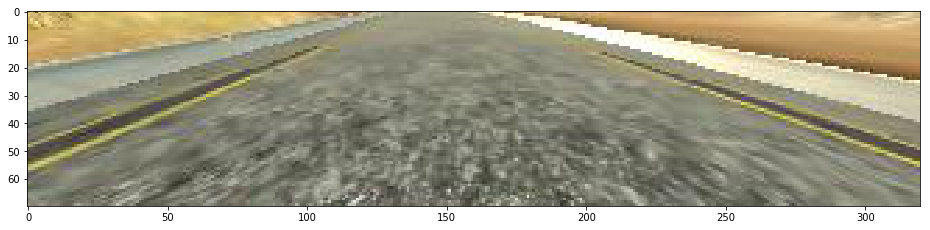

In [18]:
plt.figure(figsize=(16,16))
plt.imshow(image[65:-25,:,:])

In [19]:
image[65:-25,:,:].shape

(70, 320, 3)